# **Working memory training**: Denoising procedure 

Procedure for denoisng of data from working memory training experiment.

Confound regression:
- aCompCor
- 24 motion parameters (Satterthwaite et al., 2013)
- outlier scans based on FD (> 0.5 mm) and DVARS (> 3 SD)
- task effects + temporal derivatives

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 09-11-2018


Step 0: Loading libraries
-----------------------

In [6]:
%matplotlib inline

import sys
sys.path.append("/Users/jan/Documents/Studia/Magisterka")
sys.path.append('..')                
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from nilearn import datasets, plotting, input_data, signal, image  
from nilearn.input_data import NiftiLabelsMasker

from nilearn.glm.first_level import make_first_level_design_matrix # changed from nistats to this, also in fctool.denoise

from fctools import denoise

In [5]:
!pwd

/Users/jan/Documents/Studia/Magisterka/WM_training_modularity_revisited/02-fmri_data_preparation


Step 1: Preparing paths to files
------------------------------

In [19]:
# Setting directories for input and output files
top_dir = '/Users/jan/Documents/Studia/Magisterka/bids/'

# Selecting subjects who finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')
subs = pd.Series.tolist(groups['sub'][groups['group'].isin(['Experimental', 'Control'])])

# Setting sessions and task names
sess = ['ses-1']
# tasks = ['dualnback']
tasks = ['rest']

suffix = '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

print(f'Sample size: {len(subs)}')

Sample size: 46


Step 2: Generating design matrix
--------------------------

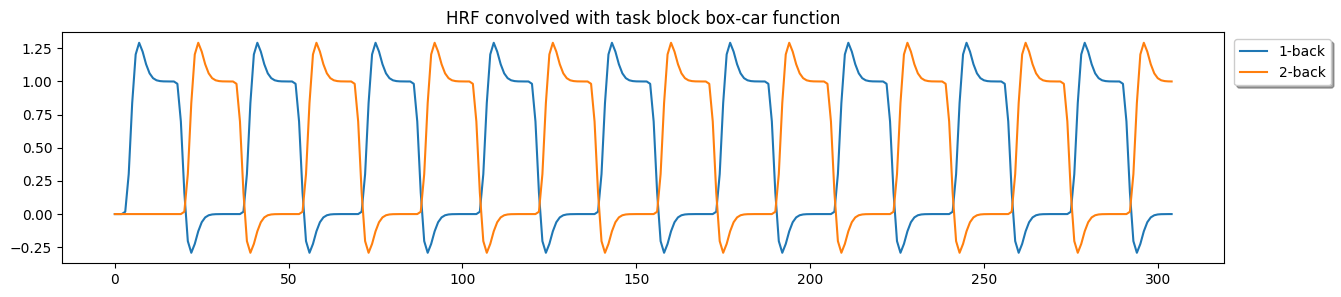

In [22]:
# Settings
t_r = 2
# n_scans = 340
n_scans = 305
frame_times = np.arange(n_scans) * t_r

# Load task-block onsets
events = pd.read_csv('../support/onsets_dualnback.csv')

# Convolving box car function with HRF
box_hrf = make_first_level_design_matrix(frame_times, events, hrf_model='glover')
box_hrf  = box_hrf.reset_index()

# Visualise
plotting_visible = ['1-back','2-back']
plt.figure(figsize=(15, 3))
plt.title('HRF convolved with task block box-car function')
for cond in plotting_visible:
    plt.plot(box_hrf[cond], label=cond)
plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1), fancybox=True, shadow=True);

Step 3: Denoising data
-----------------------

In [23]:
for sub in subs:
    print(f'Denoising {sub}')
    for ses in sess:
        print(f'- {ses}')
        for task in tasks:
            
            # Getting directory/file names
            sub_dir = f'{top_dir}{sub}/{ses}/func/'
            sub_name = f'{sub}_{ses}_task-{task}' 
            epi_preproc_path = f'{sub_dir}{sub_name}{suffix}'
            
            # Loading confound data
            confounds_path = f'{sub_dir}{sub_name}_desc-confounds_regressors.tsv'
            
            if not os.path.exists(confounds_path):
                 print(f'{sub}-{ses}-{task} does not exist')
            else:
                
                # Reading confounds table
                confounds = pd.read_csv(confounds_path, delimiter='\t')
                
                # Selecting columns of interest 
                confounds_motion = confounds[confounds.filter(regex='X|Y|Z|RotX|RotY|RotZ').columns]
                confounds_acompcor = confounds[confounds.filter(regex='aCompCor').columns]
                confounds_scrub = confounds[confounds.filter(regex='vx-wisestdDVARS|Framewise').columns]

                # Calculating additional motion parameters (temporal derivatives + quadratic terms)
                confounds_motion_td = denoise.temp_deriv(confounds_motion, quadratic=True) # extended motion confounds
                
                # Detecting outliers 
                # confounds_scrub_td = denoise.temp_deriv(denoise.outliers_fd_dvars(confounds_scrub, fd=0.5, dvars=3), quadratic=False)
               
                # Calculating task effects
                task_effects_td = denoise.temp_deriv(pd.DataFrame(box_hrf, columns=['intro', '1-back', '2-back']), quadratic=False)
                
                # Concatenating columns #removed this --> confounds_scrub_td,
                confounds_clean = pd.concat([confounds_acompcor, 
                                             confounds_motion_td, 
                                             task_effects_td,
                                            ], axis=1)

                # Saving preprocessed confound file
                confounds_clean.to_csv(f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv', sep=',', index=False)
                confounds_clean_path = f'{sub_dir}{sub_name}_bold_confounds_clean_acompcor.csv'

                # Voxel-vise signal denoising
                denoised_nifti = image.clean_img(epi_preproc_path, 
                                                 confounds=confounds_clean_path, 
                                                 detrend=True, 
                                                 standardize=False,
                                                )
                
                # Saving denoised file
                denoised_nifti.to_filename(f'{sub_dir}{sub_name}{suffix[:-7]}_denoised_acompcor_task_effects.nii.gz')

Denoising sub-01
- ses-1
Denoising sub-02
- ses-1
Denoising sub-04
- ses-1
Denoising sub-05
- ses-1
Denoising sub-06
- ses-1
Denoising sub-07
- ses-1
Denoising sub-08
- ses-1
Denoising sub-10
- ses-1
Denoising sub-11
- ses-1
Denoising sub-12
- ses-1
Denoising sub-13
- ses-1
Denoising sub-14
- ses-1
Denoising sub-15
- ses-1
Denoising sub-16
- ses-1
Denoising sub-18
- ses-1
Denoising sub-19
- ses-1
Denoising sub-20
- ses-1
Denoising sub-21
- ses-1
Denoising sub-23
- ses-1
Denoising sub-24
- ses-1
Denoising sub-25
- ses-1
Denoising sub-26
- ses-1
Denoising sub-27
- ses-1
Denoising sub-28
- ses-1
Denoising sub-29
- ses-1
Denoising sub-30
- ses-1
Denoising sub-33
- ses-1
Denoising sub-35
- ses-1
Denoising sub-36
- ses-1
Denoising sub-37
- ses-1
Denoising sub-39
- ses-1
Denoising sub-41
- ses-1
Denoising sub-42
- ses-1
Denoising sub-43
- ses-1
Denoising sub-44
- ses-1
Denoising sub-45
- ses-1
Denoising sub-46
- ses-1
Denoising sub-47
- ses-1
Denoising sub-48
- ses-1
Denoising sub-50
- ses-1
